In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorboard.backend.event_processing import event_accumulator

In [2]:
RUN_NAME = "64_PRP_woERA5_rot904_3e-4"
BASE_DIR = f"/vol/bitbucket/pn222/models/{RUN_NAME}"
SAVE = True

In [3]:
log_files = sorted(glob.glob(BASE_DIR + "/runs/*/*"))

In [4]:
mse1_df = pd.DataFrame()

for log_file in log_files:
    ea = event_accumulator.EventAccumulator(log_file)
    ea.Reload()
    df = pd.DataFrame(ea.Scalars('MSE_1'))
    mse1_df = pd.concat([mse1_df, df], axis=0)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def generate_plot(ax, x, y, x_label, y_label, window=25):
    rolling_avg = y.rolling(window=window, min_periods=1).mean()
    ax.plot(x, rolling_avg, c='b', label=f"{window} | Rolling Avg.")
    ax.grid(True, linestyle='--')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

def generate_mean_line(ax, x, y):
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x.values.reshape(-1, 1))
    
    model = LinearRegression()
    model.fit(x_poly, y.values.reshape(-1, 1))
    y_pred = model.predict(x_poly)

    ax.plot(x, y_pred, c='r', label=f"Mean Line")

    print(f"Mean Line MSE Min: {y_pred.min():.2E}")

Mean Line MSE Min: 1.02E-03


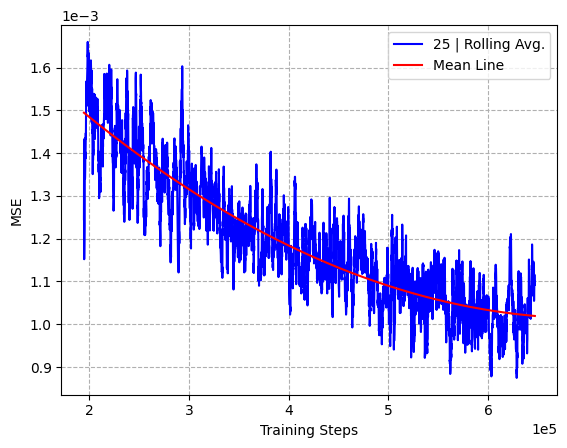

In [6]:
LIMIT = int(0.7*len(mse1_df))

fig = plt.figure()
ax  = fig.gca()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

x = mse1_df['step'][-LIMIT:]
y = mse1_df['value'][-LIMIT:]
generate_plot(ax, x, y, "Training Steps", "MSE", window=25)
generate_mean_line(ax, x, y)
ax.legend()

if SAVE: plt.savefig(f"../pngs/64_PRP/mse_{RUN_NAME}.png")
plt.show()